In [0]:
# Import the machine learning libraries.
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from sklearn.metrics import r2_score
from sklearn import metrics

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [127]:
# Load the house price dataset.
# The dataset can be downloaded here: https://github.com/ageron/handson-ml/tree/master/datasets/housing.
%%time
housing = pd.read_csv('./drive/My Drive/ML_Code/House Price Regression/Housing.csv')

CPU times: user 7.75 ms, sys: 186 µs, total: 7.94 ms
Wall time: 14.1 ms


In [128]:
housing.head(10)

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished
5,10850000,7500,3,3,1,yes,no,yes,no,yes,2,yes,semi-furnished
6,10150000,8580,4,3,4,yes,no,no,no,yes,2,yes,semi-furnished
7,10150000,16200,5,3,2,yes,no,no,no,no,0,no,unfurnished
8,9870000,8100,4,1,2,yes,yes,yes,no,yes,2,yes,furnished
9,9800000,5750,3,2,4,yes,yes,no,no,yes,1,yes,unfurnished


### **Data Preparatioin**

In [0]:
# Converting Yes to 1 and No to 0.
housing['mainroad'] = housing['mainroad'].map({'yes': 1, 'no': 0})
housing['guestroom'] = housing['guestroom'].map({'yes': 1, 'no': 0})
housing['basement'] = housing['basement'].map({'yes': 1, 'no': 0})
housing['hotwaterheating'] = housing['hotwaterheating'].map({'yes': 1, 'no': 0})
housing['airconditioning'] = housing['airconditioning'].map({'yes': 1, 'no': 0})
housing['prefarea'] = housing['prefarea'].map({'yes': 1, 'no': 0})

In [130]:
housing.head(10)

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,furnished
1,12250000,8960,4,4,4,1,0,0,0,1,3,0,furnished
2,12250000,9960,3,2,2,1,0,1,0,0,2,1,semi-furnished
3,12215000,7500,4,2,2,1,0,1,0,1,3,1,furnished
4,11410000,7420,4,1,2,1,1,1,0,1,2,0,furnished
5,10850000,7500,3,3,1,1,0,1,0,1,2,1,semi-furnished
6,10150000,8580,4,3,4,1,0,0,0,1,2,1,semi-furnished
7,10150000,16200,5,3,2,1,0,0,0,0,0,0,unfurnished
8,9870000,8100,4,1,2,1,1,1,0,1,2,1,furnished
9,9800000,5750,3,2,4,1,1,0,0,1,1,1,unfurnished


In [0]:
# Create dummy variables for 'furnishingstatus' column and drop the first column.
# Convert categorical variable into dummy/indicator variables.
status = pd.get_dummies(housing['furnishingstatus'], drop_first=True)
# OR
# Create dummy variable for 'furnishingstatus' column.
# status = pd.get_dummies(housing['furnishingstatus'])

In [132]:
status.head(10)

,semi-furnished,unfurnished
0,0,0
1,0,0
2,1,0
3,0,0
4,0,0
5,1,0
6,1,0
7,0,1
8,0,0
9,0,1


In [0]:
# Insert the created dummy variables into the housing dataframe.
housing = pd.concat([housing,status], axis=1)

In [134]:
housing.head(10)

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus,semi-furnished,unfurnished
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,furnished,0,0
1,12250000,8960,4,4,4,1,0,0,0,1,3,0,furnished,0,0
2,12250000,9960,3,2,2,1,0,1,0,0,2,1,semi-furnished,1,0
3,12215000,7500,4,2,2,1,0,1,0,1,3,1,furnished,0,0
4,11410000,7420,4,1,2,1,1,1,0,1,2,0,furnished,0,0
5,10850000,7500,3,3,1,1,0,1,0,1,2,1,semi-furnished,1,0
6,10150000,8580,4,3,4,1,0,0,0,1,2,1,semi-furnished,1,0
7,10150000,16200,5,3,2,1,0,0,0,0,0,0,unfurnished,0,1
8,9870000,8100,4,1,2,1,1,1,0,1,2,1,furnished,0,0
9,9800000,5750,3,2,4,1,1,0,0,1,1,1,unfurnished,0,1


In [0]:
# Drop the 'furnishingstatus' column.
housing.drop(['furnishingstatus'], axis=1, inplace=True)

In [136]:
housing.head(10)

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,semi-furnished,unfurnished
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,0,0
1,12250000,8960,4,4,4,1,0,0,0,1,3,0,0,0
2,12250000,9960,3,2,2,1,0,1,0,0,2,1,1,0
3,12215000,7500,4,2,2,1,0,1,0,1,3,1,0,0
4,11410000,7420,4,1,2,1,1,1,0,1,2,0,0,0
5,10850000,7500,3,3,1,1,0,1,0,1,2,1,1,0
6,10150000,8580,4,3,4,1,0,0,0,1,2,1,1,0
7,10150000,16200,5,3,2,1,0,0,0,0,0,0,0,1
8,9870000,8100,4,1,2,1,1,1,0,1,2,1,0,0
9,9800000,5750,3,2,4,1,1,0,0,1,1,1,0,1


In [0]:
# Create the new column, area per bedrooms.
housing['areaperbedroom'] = housing['area']/housing['bedrooms']

In [0]:
# Create the new column, bathrooms per bedroom.
housing['bbratio'] = housing['bathrooms']/housing['bedrooms']

### **Min-Max Normalization**

In [0]:
# Define a Min-Max Normalisation function.
# sklearn.preprocessing.MinMaxScaler can also be used instead of this user-defined function.
def normalize (x): 
    return ( (x-np.min(x)) / (max(x)-min(x)))                                            
                                              
# Apply Min-Max Normalization.
housing = housing.apply(normalize)

### **Correlation**

<Figure size 720x720 with 0 Axes>

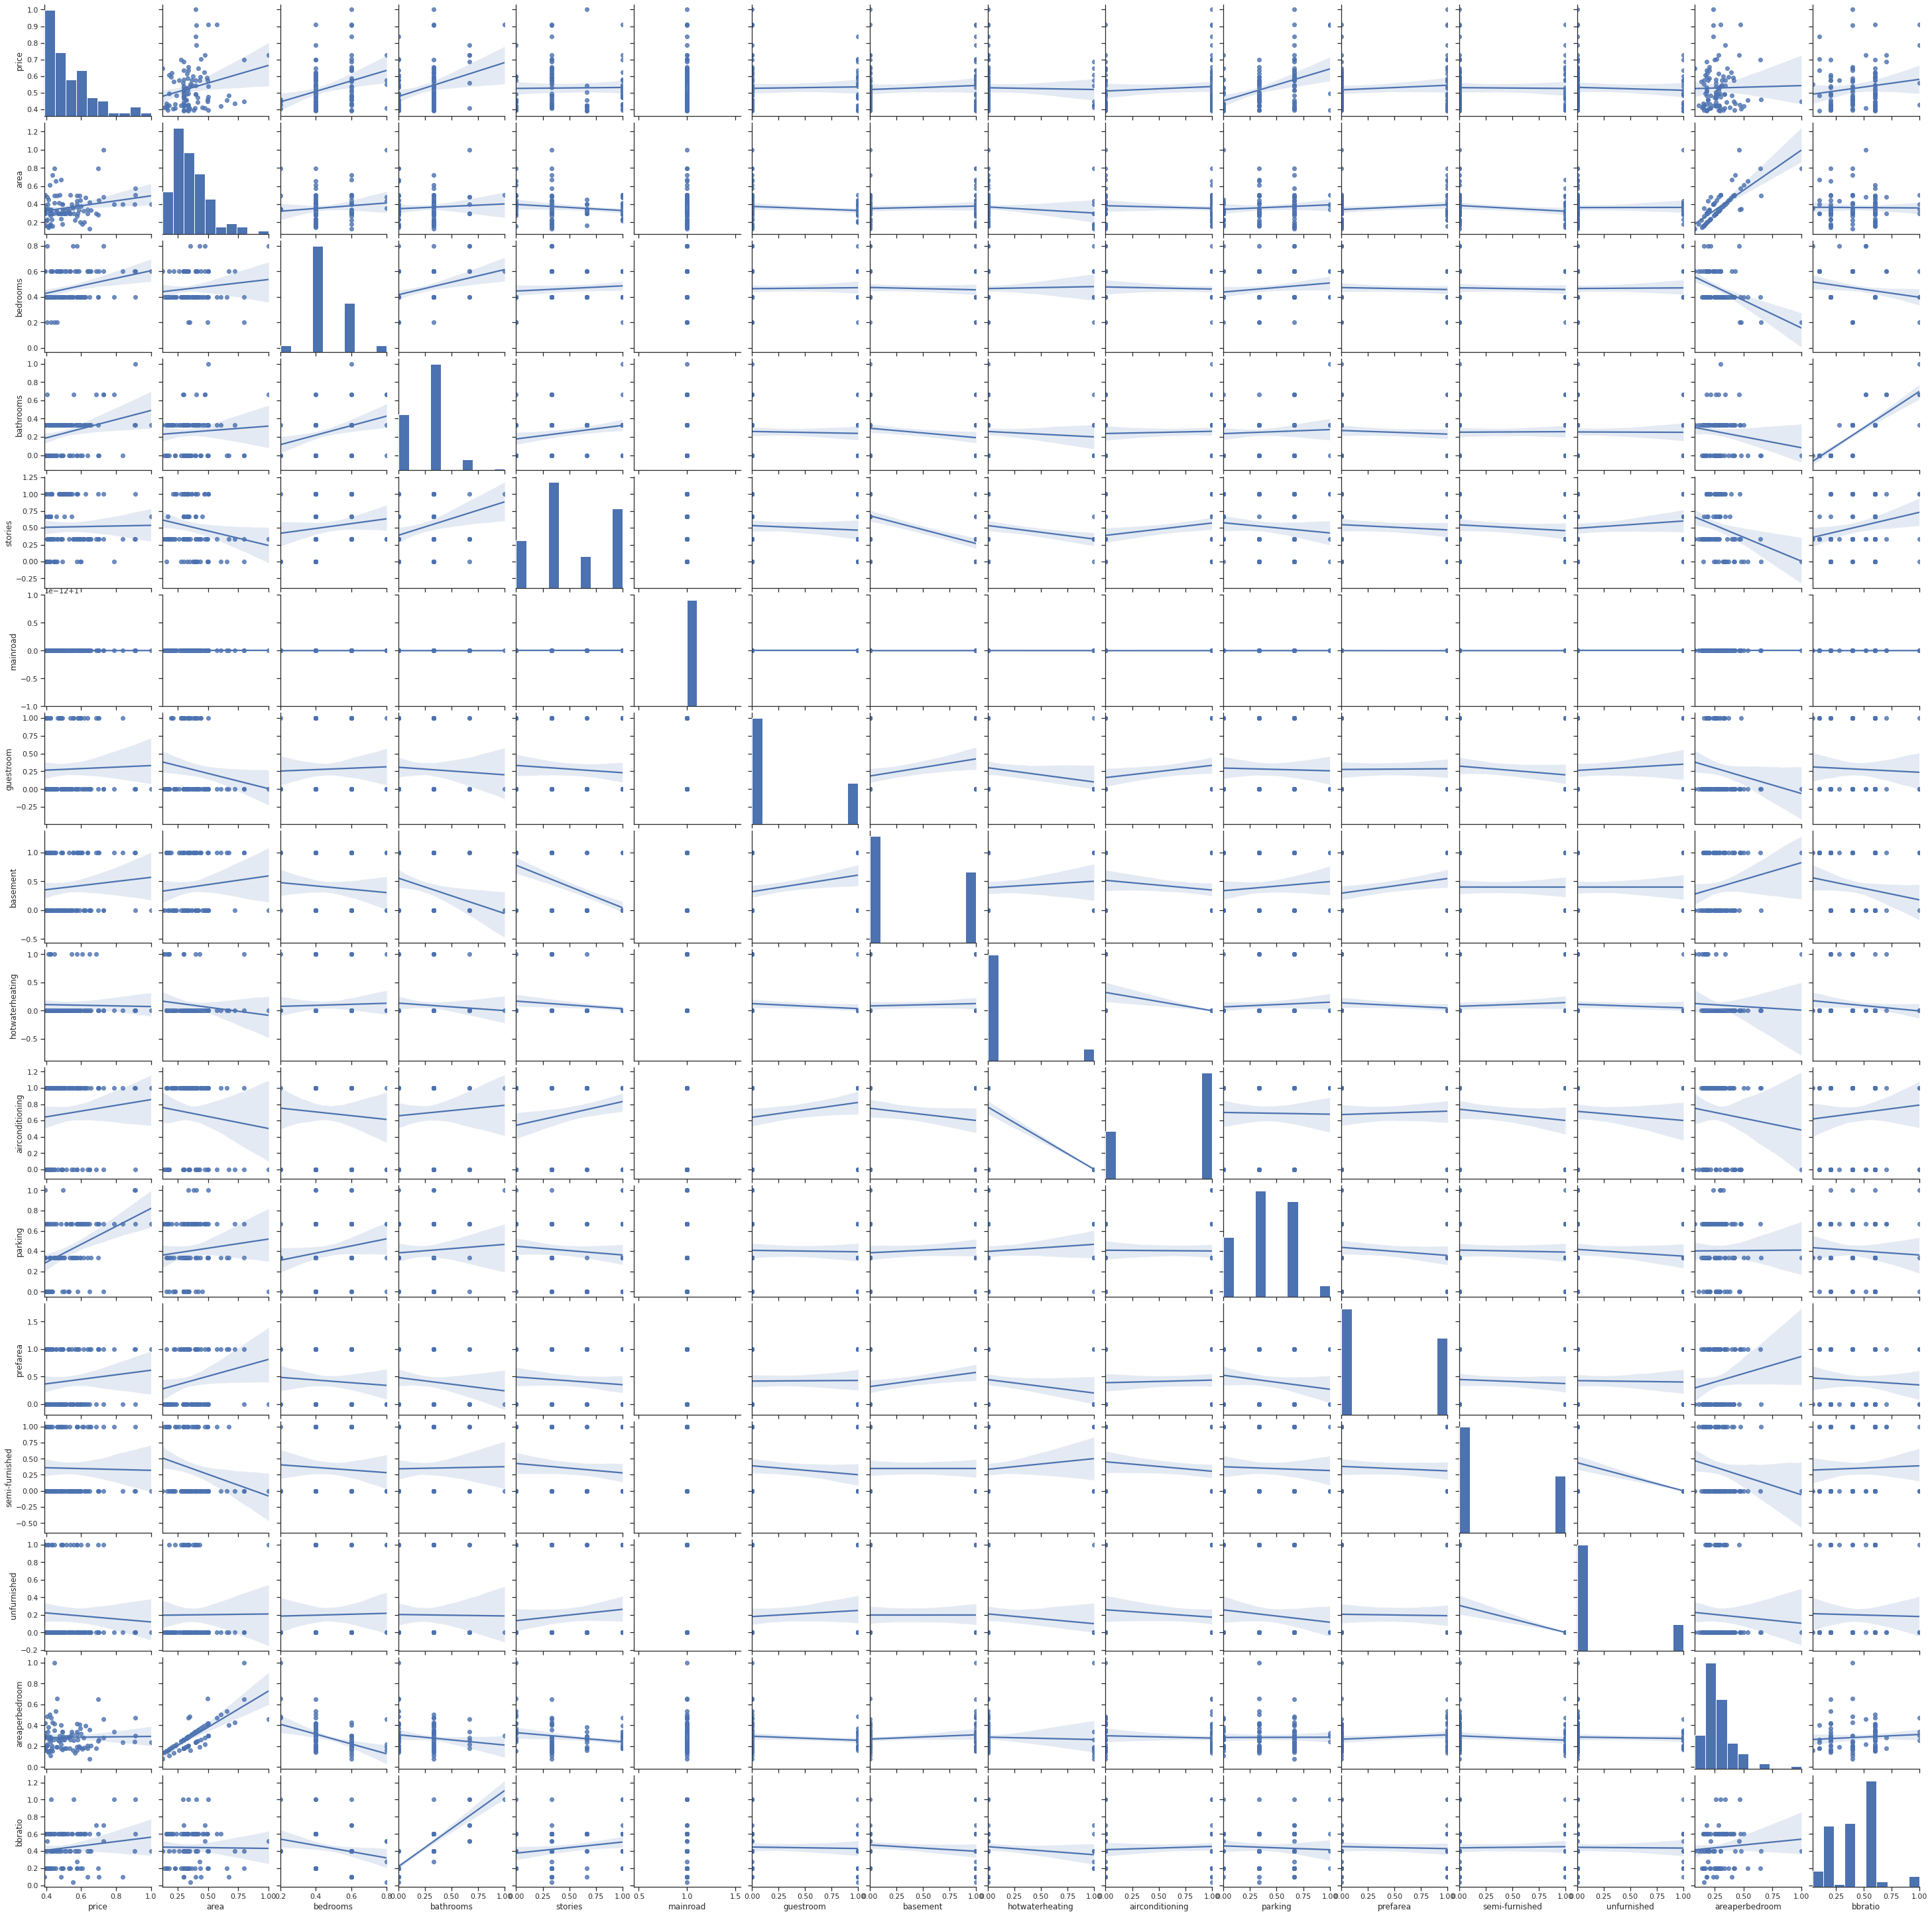

CPU times: user 1min 45s, sys: 23.1 s, total: 2min 8s
Wall time: 1min 41s


In [140]:
# Make a paiwise scatter plot.
%%time
plt.figure(figsize=(10, 10))
sns.set(style="ticks", color_codes=True)
sns.pairplot(housing[:100], kind="reg") # To save time, consider 100 rows only.
plt.show()

In [141]:
# Display correlation matrix.
cor = housing.corr()
cor

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,semi-furnished,unfurnished,areaperbedroom,bbratio
price,1.000000,0.535997,0.366494,0.517545,0.420712,0.296898,0.255517,0.187057,0.093073,0.452954,0.384394,0.329777,0.063656,-0.280587,0.244809,0.231732
area,0.535997,1.000000,0.151858,0.193820,0.083996,0.288874,0.140297,0.047417,-0.009229,0.222393,0.352980,0.234779,0.006156,-0.142278,0.805610,0.057116
bedrooms,0.366494,0.151858,1.000000,0.373930,0.408564,-0.012033,0.080549,0.097312,0.046049,0.160603,0.139270,0.079023,0.050040,-0.126252,-0.397259,-0.317303
bathrooms,0.517545,0.193820,0.373930,1.000000,0.326165,0.042398,0.126469,0.102106,0.067159,0.186915,0.177496,0.063472,0.029834,-0.132107,-0.052352,0.727154
stories,0.420712,0.083996,0.408564,0.326165,1.000000,0.121706,0.043538,-0.172394,0.018847,0.293602,0.045547,0.044425,-0.003648,-0.082972,-0.178942,0.032962
mainroad,0.296898,0.288874,-0.012033,0.042398,0.121706,1.000000,0.092337,0.044002,-0.011781,0.105423,0.204433,0.199876,0.011450,-0.133123,0.249829,0.030407
guestroom,0.255517,0.140297,0.080549,0.126469,0.043538,0.092337,1.000000,0.372066,-0.010308,0.138179,0.037466,0.160897,0.005821,-0.099023,0.054312,0.075854
basement,0.187057,0.047417,0.097312,0.102106,-0.172394,0.044002,0.372066,1.000000,0.004385,0.047341,0.051497,0.228083,0.050284,-0.117935,-0.017034,0.047346
hotwaterheating,0.093073,-0.009229,0.046049,0.067159,0.018847,-0.011781,-0.010308,0.004385,1.000000,-0.130023,0.067864,-0.059411,0.063819,-0.059194,-0.021634,0.021520
airconditioning,0.452954,0.222393,0.160603,0.186915,0.293602,0.105423,0.138179,0.047341,-0.130023,1.000000,0.159173,0.117382,-0.053179,-0.094086,0.096830,0.064649


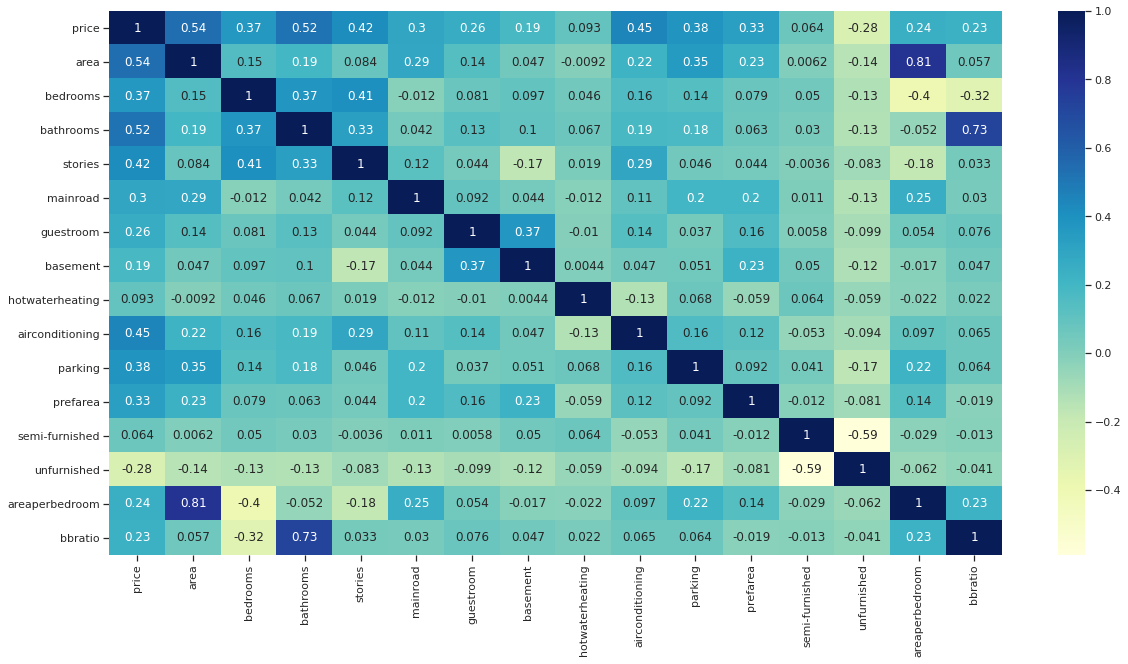

In [142]:
# Plot correlations on a heatmap.
plt.figure(figsize=(20,10))
sns.heatmap(cor, cmap="YlGnBu", annot=True)
plt.show()

### **Split the dataset into the training and testing subsets.**

In [0]:
# Split a dataset into X and y.
X = housing[['area', 'bedrooms', 'bathrooms', 'stories', 'mainroad',
       'guestroom', 'basement', 'hotwaterheating', 'airconditioning',
       'parking', 'prefarea', 'semi-furnished', 'unfurnished',
       'areaperbedroom', 'bbratio']]
y = housing['price']

In [144]:
X.head()

,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,semi-furnished,unfurnished,areaperbedroom,bbratio
0,0.396564,0.6,0.333333,0.666667,1.0,0.0,0.0,0.0,1.0,0.666667,1.0,0.0,0.0,0.237016,0.4
1,0.502405,0.6,1.000000,1.000000,1.0,0.0,0.0,0.0,1.0,1.000000,0.0,0.0,0.0,0.298923,1.0
2,0.571134,0.4,0.333333,0.333333,1.0,0.0,1.0,0.0,0.0,0.666667,1.0,1.0,0.0,0.472584,0.6
3,0.402062,0.6,0.333333,0.333333,1.0,0.0,1.0,0.0,1.0,1.000000,1.0,0.0,0.0,0.240232,0.4
4,0.396564,0.6,0.000000,0.333333,1.0,1.0,1.0,0.0,1.0,0.666667,0.0,0.0,0.0,0.237016,0.1


In [0]:
# Split the dataset into the training and testing subsets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [0]:
# Define function for calculating the Variance Inflation Factor (VIF) value.
def vif_cal(input_data, dependent_col):
    vif_df = pd.DataFrame(columns = ['Var', 'Vif'])
    x_vars = input_data.drop([dependent_col], axis=1)
    xvar_names = x_vars.columns
    for i in range(0, xvar_names.shape[0]):
        y = x_vars[xvar_names[i]] 
        x = x_vars[xvar_names.drop(xvar_names[i])]
        rsq = sm.OLS(y,x).fit().rsquared  
        vif = round(1/(1-rsq), 2)
        vif_df.loc[i] = [xvar_names[i], vif]
    return vif_df.sort_values(by = 'Vif', axis=0, ascending=False, inplace=False)

### **Recursive Feature Elimination (RFE)**

In [147]:
# Run the recursive feature elimination (RFE) with the output number of the features equal to 9.
lr = LinearRegression()
rfe = RFE(lr, 9)
rfe = rfe.fit(X_train, y_train)
print(rfe.support_)
print(rfe.ranking_)

[ True  True  True  True False False False  True  True  True  True False
 False  True False]
[1 1 1 1 4 3 6 1 1 1 1 7 5 1 2]


In [148]:
col = X_train.columns[rfe.support_]
col

Index(['area', 'bedrooms', 'bathrooms', 'stories', 'hotwaterheating',
       'airconditioning', 'parking', 'prefarea', 'areaperbedroom'],
      dtype='object')

In [0]:
# Creat X_train dataframe with RFE-selected features.
X_train_rfe = X_train[col]

In [150]:
X_train_rfe.head(10)

,area,bedrooms,bathrooms,stories,hotwaterheating,airconditioning,parking,prefarea,areaperbedroom
454,0.195876,0.4,0.000000,0.333333,0.0,1.0,0.000000,0.0,0.179932
392,0.160825,0.4,0.000000,0.333333,0.0,0.0,0.000000,0.0,0.152597
231,0.183505,0.4,0.000000,0.000000,0.0,0.0,0.000000,1.0,0.170285
271,0.017526,0.8,0.000000,0.333333,0.0,0.0,0.000000,0.0,0.000000
250,0.127835,0.4,0.000000,0.666667,0.0,0.0,0.000000,0.0,0.126869
541,0.051546,0.4,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.067374
461,0.227491,0.2,0.000000,0.000000,0.0,1.0,0.000000,0.0,0.337514
124,0.335052,0.4,0.333333,1.000000,0.0,0.0,0.333333,0.0,0.288471
154,0.137457,0.4,0.333333,0.333333,0.0,0.0,0.666667,0.0,0.134373
451,0.350515,0.2,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.481428


In [0]:
# Add a constant column.
X_train_rfe = sm.add_constant(X_train_rfe)

In [152]:
X_train_rfe.head(10)

,const,area,bedrooms,bathrooms,stories,hotwaterheating,airconditioning,parking,prefarea,areaperbedroom
454,1.0,0.195876,0.4,0.000000,0.333333,0.0,1.0,0.000000,0.0,0.179932
392,1.0,0.160825,0.4,0.000000,0.333333,0.0,0.0,0.000000,0.0,0.152597
231,1.0,0.183505,0.4,0.000000,0.000000,0.0,0.0,0.000000,1.0,0.170285
271,1.0,0.017526,0.8,0.000000,0.333333,0.0,0.0,0.000000,0.0,0.000000
250,1.0,0.127835,0.4,0.000000,0.666667,0.0,0.0,0.000000,0.0,0.126869
541,1.0,0.051546,0.4,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.067374
461,1.0,0.227491,0.2,0.000000,0.000000,0.0,1.0,0.000000,0.0,0.337514
124,1.0,0.335052,0.4,0.333333,1.000000,0.0,0.0,0.333333,0.0,0.288471
154,1.0,0.137457,0.4,0.333333,0.333333,0.0,0.0,0.666667,0.0,0.134373
451,1.0,0.350515,0.2,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.481428


### **Linear Regression**

In [0]:
# Run the Ordinary Least Squares (OLS) linear model.
# See https://www.statsmodels.org/devel/generated/statsmodels.regression.linear_model.OLS.html.
lr = sm.OLS(y_train, X_train_rfe).fit()

In [154]:
# Print the summary of the OLS linear model.
print(lr.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.625
Model:                            OLS   Adj. R-squared:                  0.616
Method:                 Least Squares   F-statistic:                     68.79
Date:                Sat, 18 Apr 2020   Prob (F-statistic):           1.26e-73
Time:                        06:01:47   Log-Likelihood:                 339.81
No. Observations:                 381   AIC:                            -659.6
Df Residuals:                     371   BIC:                            -620.2
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0862      0.040     

In [155]:
# Calculate VIF values without not REF-selected features.
vif_cal(input_data=housing.drop(['area','bedrooms','stories','basement','semi-furnished','areaperbedroom'], axis=1), dependent_col="price")

,Var,Vif
8,bbratio,6.21
1,mainroad,4.66
0,bathrooms,2.78
5,parking,1.82
4,airconditioning,1.59
7,unfurnished,1.44
6,prefarea,1.41
2,guestroom,1.28
3,hotwaterheating,1.08


In [0]:
# Creat X_test dataframe with RFE-selected features.
X_test_rfe = X_test[col]

# Add a constant column.
X_test_rfe = sm.add_constant(X_test_rfe)

# Make predictions.
y_pred = lr.predict(X_test_rfe)

In [157]:
# Calculate R^2 score.
r2_score = r2_score(y_test, y_pred)
print(r2_score)
print("R^2 Score: %f" % r2_score)

0.7063757091986063
R^2 Score: 0.706376


In [158]:
# Calculate Root Mean Square Error.
rmse_score = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
print('RMSE:', rmse_score)

RMSE: 0.08737798843738173


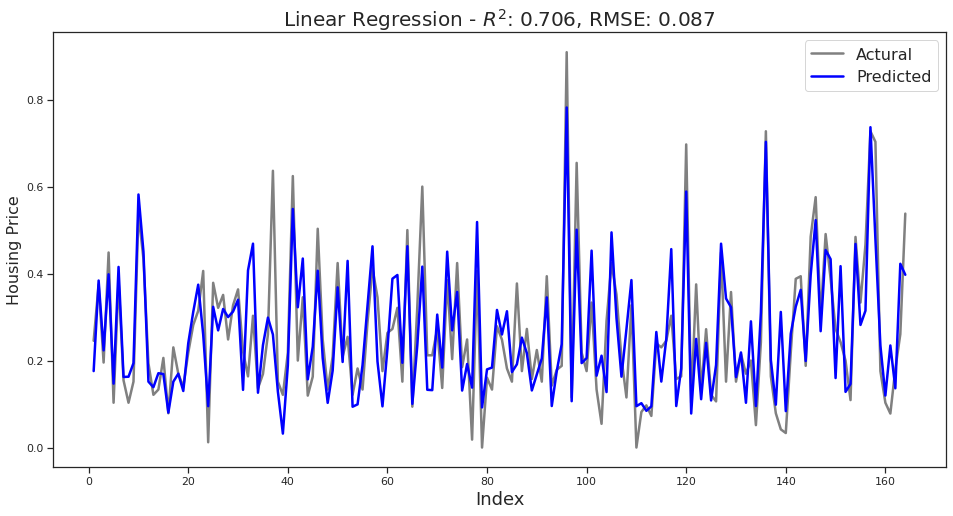

In [159]:
# Plot actual and predicted housing prices.
c = [i for i in range(1,165,1)] # generating index 
fig = plt.figure(figsize=(16,8))
plt.plot(c, y_test, color="gray", linewidth=2.5, linestyle="-")
plt.plot(c, y_pred, color="blue",  linewidth=2.5, linestyle="-")
plt.title("Linear Regression - $R^2$: %.3f, RMSE: %.3f" % (r2_score, rmse_score), fontsize=20)
#plt.title("Linear Regression $R^2$: %.3f" % (r2_score), fontsize=20)
plt.xlabel('Index', fontsize=18)
plt.ylabel('Housing Price', fontsize=16)
plt.legend(['Actural', 'Predicted'], loc='upper right', fontsize=16)

Text(0, 0.5, 'ytest-ypred')

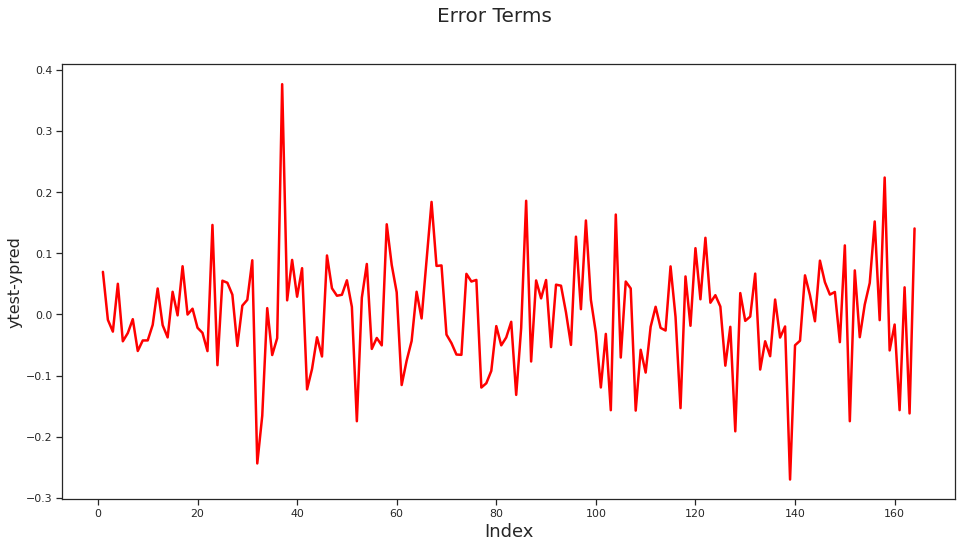

In [160]:
# Plot Error terms
c = [i for i in range(1,165,1)]
fig = plt.figure(figsize=(16,8))
plt.plot(c, y_test-y_pred, color="red", linewidth=2.5, linestyle="-")
fig.suptitle('Error Terms', fontsize=20)
plt.xlabel('Index', fontsize=18)
plt.ylabel('ytest-ypred', fontsize=16)

Text(0, 0.5, 'y_pred')

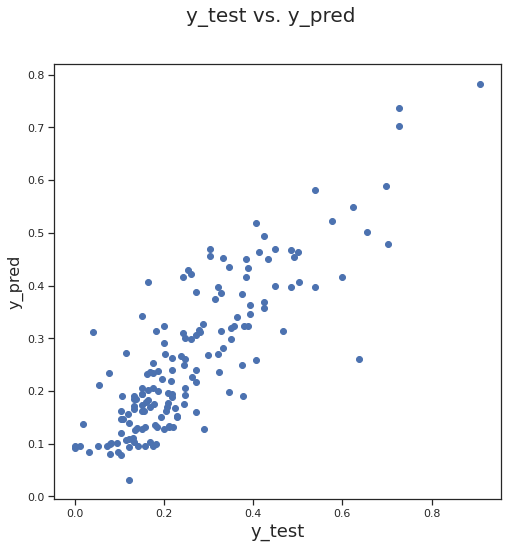

In [161]:
# Scatter Plot y_test and y_pred.
fig = plt.figure(figsize=(8,8))
plt.scatter(y_test, y_pred)
fig.suptitle('y_test vs. y_pred', fontsize=20)
plt.xlabel('y_test', fontsize=18)
plt.ylabel('y_pred', fontsize=16)

Text(0, 0.5, 'Index')

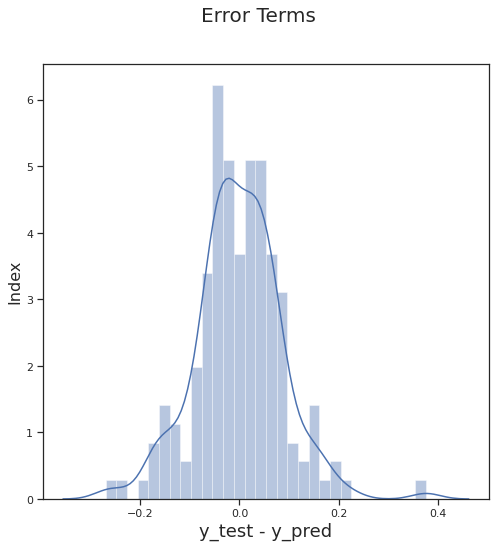

In [162]:
# Plot the histogram of the error terms.
fig = plt.figure(figsize=(8,8))
sns.distplot((y_test-y_pred), bins=30)
fig.suptitle('Error Terms', fontsize=20)
plt.xlabel('y_test - y_pred', fontsize=18)
plt.ylabel('Index', fontsize=16)